In [1]:
import sys
import os
import importlib
import pandas as pd
import numpy as np
import geopandas
import seaborn
sys.path.insert(0, os.path.join(os.environ["DESEABEL_PATH"], "ocean_ecosystem"))
from ocean_ecosystem import noise_impactor
from ocean_ecosystem import simulator
from ocean_ecosystem import marine_fauna
from ocean_ecosystem import marine_map
from ocean_ecosystem import matrix_conversion
importlib.reload(matrix_conversion)
importlib.reload(marine_map)
importlib.reload(marine_fauna)
importlib.reload(simulator)
importlib.reload(noise_impactor)

from noise_impactor import FishingBoat, PileDriving
from simulator import Simulator
from marine_fauna import Fish
from marine_map import MarineMap
from matrix_conversion import *

## Create 3 boats and one fish species

In [2]:
boat1 = FishingBoat(id=1, lat=45.20, lon=-5.2, speed=10, length=10)
boat2 = FishingBoat(id=2, lat=44.85, lon=-4.9, speed=15, length=13)
boat3 = FishingBoat(id=3, lat=44.5, lon=-5.2, speed=17, length=5)

path_data = "s3://deseabel/marine_fauna/fish.geojson"

fish = Fish(path_data)

## Initialize a marine map with specific shapes

In [3]:
# Example
width = 300000
height = 300000
step = 1000
longitude_west = -6.40953
latitude_north = 46.41813

marine_map = MarineMap(width, height, step, longitude_west, latitude_north)

## Initialize a Simulator

In [4]:
simu = Simulator(marine_map, list_noise_impactor=[boat1, boat2], list_marine_fauna=[])

# Add manually other objects
simu.add_noise_impactor(boat3)
simu.add_marine_fauna(fish)

#### Plot the heatmap of the noise from the map

<AxesSubplot: >

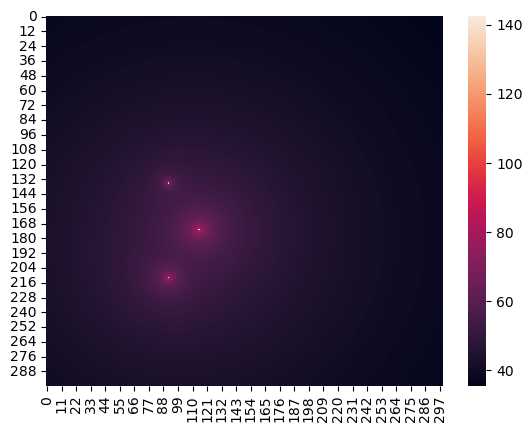

In [5]:
#marine_map.matrix_decibel_gpd.to_file(".data/matrix_decibel.geojson", driver="GeoJSON")
seaborn.heatmap(marine_map.matrix_decibel)

## Compute the marine fauna impact for the fish species

In [6]:
simu.update_marine_fauna_impact("fish")

#### Show different results
1. Plot the corresponding quantified matrix of the different levels of noise impacts
2. Print the corresponding array impact
3. Plot The corresponding location of the fish species

<AxesSubplot: >

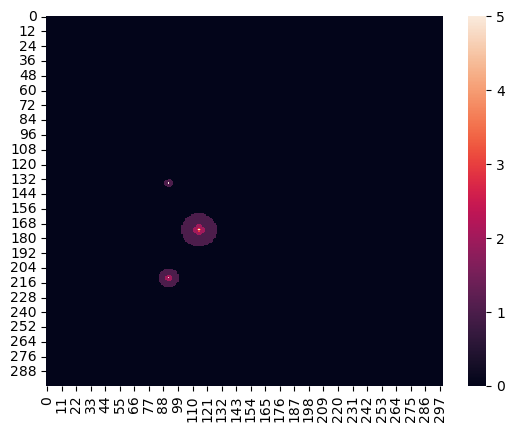

In [7]:
#marine_map.matrix_decibel_impact_quantified_gpd.to_file("../data/matrix_decibel_impact_quantified", driver="GeoJSON")
seaborn.heatmap(marine_map.matrix_decibel_impact_quantified)

In [8]:
# with open(f"../data/array_impact_{fish._species}.json", "w") as f_out:
#     json.dump({i: impact for i, impact in enumerate(fish.array_impact)}, f_out)
fish.array_impact

array([0.99745732, 0.00254268, 0.        , 0.        , 0.        ,
       0.        ])

<AxesSubplot: >

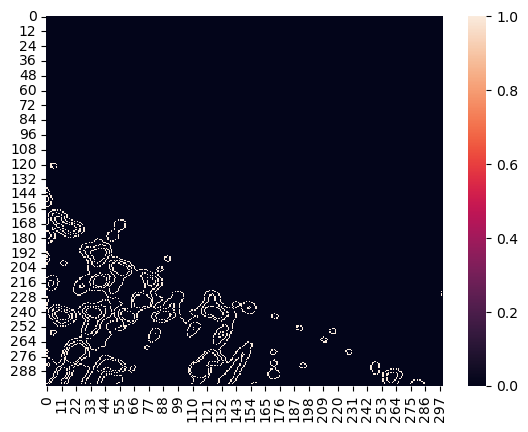

In [9]:
coords = marine_map.get_coords_xy_from_geopandas(fish.spot_gpd)
matrix_res = np.zeros(marine_map.matrix_decibel.shape)

matrix_res[coords[:, 0], coords[:, 1]] = 1

seaborn.heatmap(matrix_res)

## Use the API

In [42]:
import requests
import os
import time
zone = "la_rochelle"
path_data = "s3://deseabel/marine_fauna/fish.geojson"
species = "fish"

# urls
url_base = "http://0.0.0.0:8000/"
url_base = "https://yvxs8x.deta.dev/"
url_show = os.path.join(url_base, f"show/{zone}")
url_init = os.path.join(url_base, "initialize_user")
url_add_boat = os.path.join(url_base, f"add_boat/fishing_boat?zone={zone}")
url_add_marine_fauna = os.path.join(url_base, f"add_marine_fauna/fish?zone={zone}&geojson_path={path_data}")
url_update_impact = os.path.join(url_base, f"update_marine_fauna_impact?zone={zone}&species={species}")
url_decibel_matrix = os.path.join(url_base, f"decibel_matrix?zone={zone}")
url_decibel_matrix_impact_quantified = os.path.join(url_base, f"decibel_matrix_impact_quantified?zone={zone}")
url_percentage_marine_fauna_impact_by_level = os.path.join(url_base, f"percentage_marine_fauna_impact_by_level?zone={zone}&species={species}")

requests.get(url_base).text

'{"message":"Welcome to the DeSEAbel API !!!"}'

In [43]:
requests.post(os.path.join(url_base, "test_post")).text

'{"key":"3oq9bn106iwd","simulator":"blabla"}'

In [55]:
requests.get(os.path.join(url_base, "test_get")).text

'<h1> Bad Gateway </h1>\n<p> The micro ran into an error while processing the request. </p>\n<p> If you are the owner of the micro, please check your logs. </p>'

In [38]:
requests.get(url_base).text

'{"message":"Welcome to the DeSEAbel API !!!"}'

In [30]:
token1 = requests.post(url_init).json()["token"]
time.sleep(1)
token2 = requests.post(url_init).json()["token"]
header1 = {"token": token1}
header2 = {"token": token2}

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [13]:
boat1 = {"id": 1, "lat": 45.20, "lon": -5.2, "speed": 10, "length": 10}
boat2 = {"id": 2, "lat": 44.85, "lon": -4.9, "speed": 15, "length": 13}
boat3 = {"id": 3, "lat": 44.5, "lon": -5.2, "speed": 17, "length": 5}
requests.post(url_add_boat, json=boat1, headers=header1)
requests.post(url_add_boat, json=boat2, headers=header1)
requests.post(url_add_boat, json=boat3, headers=header1)
# id_to_del = 2
# url_delete_boat = os.path.join(url_base, f"remove_noise_impactor?id={id_to_del}")
# requests.get(url_delete_boat).text

<Response [200]>

In [14]:
requests.get(url_show, headers=header1).text

'{"noise_impactors":"[<ocean_ecosystem.noise_impactor.FishingBoat object at 0x7f1e07c4fd90>, <ocean_ecosystem.noise_impactor.FishingBoat object at 0x7f1dff3b9550>, <ocean_ecosystem.noise_impactor.FishingBoat object at 0x7f1e277e2550>]","marine_faunas":"[]"}'

In [15]:
requests.get(url_show, headers=header2).text

'{"noise_impactors":"[]","marine_faunas":"[]"}'

In [16]:
requests.post(url_add_marine_fauna, headers=header1).text
# species_to_del = "fish"
# url_delete_species = os.path.join(url_base, f"remove_marine_fauna?species={species_to_del}")
# requests.delete(url_delete_species).text

'{"message":"The fish marine fauna has been added in the environment."}'

In [17]:
requests.get(url_show, headers=header1).text

'{"noise_impactors":"[<ocean_ecosystem.noise_impactor.FishingBoat object at 0x7f1e07c4fd90>, <ocean_ecosystem.noise_impactor.FishingBoat object at 0x7f1dff3b9550>, <ocean_ecosystem.noise_impactor.FishingBoat object at 0x7f1e277e2550>]","marine_faunas":"[<ocean_ecosystem.marine_fauna.Fish object at 0x7f1e051c0df0>]"}'

In [18]:
requests.post(url_update_impact, headers=header1)

<Response [200]>

In [19]:
res = requests.get(url_decibel_matrix, headers=header1)

In [20]:
res = requests.get(url_decibel_matrix_impact_quantified, headers=header1)

In [21]:
res = requests.get(url_percentage_marine_fauna_impact_by_level, headers=header1)

In [22]:
res.text

'{"result":{"0":0.9974573192880494,"1":0.0025426807119505995,"2":0.0,"3":0.0,"4":0.0,"5":0.0}}'